In [0]:
# default_exp data.exploratory

# Exploration of your data

> This module comprises all the statistical and inference techniques to describe the inner properties of software data. The submodules might include:
>
> - Descriptive statistics
> - Software Metrics
> - Information Theory
> - Learning Principels Detection (Occams' Razor, Biased data, and Data Snooping)
> - Inference: Probabilistic and Causal

In [2]:
!pip install dit
!pip install sentencepiece

In [0]:
# export
# Imports
import pandas as pd
import sentencepiece as sp
import dit

import os

In [0]:
# #hide
# from nbdev.showdoc import *

In [0]:
#Import dataframe from MongoDB
def simulate_getting_dataframes_from_mongo():
  requirements = {'file_name': [], 'contents': []}
  path = "./requirements"
  for file in os.listdir(path):
    requirements['file_name'].append(file)
    with open (os.path.join(path, file), "r") as f:
      requirements['contents'].append(f.read())
  source_code = {'file_name': [], 'contents': []}
  path = "./source_code"
  for file in os.listdir("./source_code"):
    source_code['file_name'].append(file)
    with open (os.path.join(path, file), "r") as f:
      source_code['contents'].append(f.read())
  req_df = pd.DataFrame(data = requirements)
  src_df = pd.DataFrame(data = source_code)
  return req_df, src_df

In [0]:
# export
def df_to_txt_file(df, output, cols):
    """Converts a dataframe and converts it into a text file that SentencePiece can use to train a BPE model"""
    if cols is None: cols = list(df.columns)
    merged_df = pd.concat([df[col] for col in cols])
    
    with open(output + '_text.txt', 'w') as f:
        f.write('\n'.join(list(merged_df)))
    return output + '_text.txt'

In [0]:
# export
def gen_sp_model(df, output, model_name, cols = None):
    """Trains a SentencePiece BPE model from a pandas dataframe"""
    fname = df_to_txt_file(df, output, cols)
    sp.SentencePieceTrainer.train(f'--input={fname} --model_prefix={output + model_name} --hard_vocab_limit=false --model_type=bpe')
    return output + model_name

In [0]:
# export
def encode_and_count(df, model_prefix):
    sp_processor = sp.SentencePieceProcessor()
    sp_processor.Load(f"{model_prefix}.model")
    tok_freq = {}
    num_tokens = 0
    for file in df.contents:
        encoding = sp_processor.encode_as_pieces(file)
        for piece in encoding:
            tok_freq.setdefault(piece, {"Occurrences": 0})
            tok_freq[piece]["Occurrences"] += 1
            num_tokens += 1
    return tok_freq, num_tokens

In [0]:
# export
def add_frequency_and_id(tok_freq, num_tokens):
    counter = 0
    for token in tok_freq:
        counter += 1
        tok_freq[token]["Frequency"] = tok_freq[token]["Occurrences"]/num_tokens
        tok_freq[token]["Outcome_Symbol"] = '0' * (10-len(str(counter))) + str(counter)
    return tok_freq

In [0]:
# export
import math
def manual_shannon(token_freqs):
    sum = 0
    for i in token_freqs:
        sum += i * math.log(1/i, 2)
    return sum

In [0]:
# export
def entropy_of_corpus(token_data):
    tokens = []
    frequencies = []
    for i in token_data:
        tokens.append(token_data[i]["Outcome_Symbol"])
        frequencies.append(token_data[i]["Frequency"])
    d = dit.Distribution(tokens, frequencies)
    return dit.shannon.entropy(d)

In [0]:
# export
def entropy_of_file(token_data, file_text, model_prefix):
    sp_processor = sp.SentencePieceProcessor()
    sp_processor.Load(f"{model_prefix}.model")
    encoding = sp_processor.encode_as_pieces(file_text)
    tokens = []
    for piece in encoding:
        tokens.append(piece)
    tokens = set(tokens)
    frequencies = [token_data[tok]["Frequency"] for tok in tokens ]
    return manual_shannon(frequencies)

In [0]:
# export 
def entropy_of_all_files(df, token_data, model_prefix):
    entropies = []
    for file in df.contents:
        entropies.append(entropy_of_file(token_data, file, model_prefix))
    return entropies

In [0]:
#export
def sort_token_data(token_data):
    return sorted(token_data.items() ,  key=lambda x: x[1]["Occurrences"])

In [0]:
#Compute entropy of all the files per system and calculate mean, std, median, and std for median absolute deviation. The idea is to create confidence intervals for each system/dataset
req_df, src_df = simulate_getting_dataframes_from_mongo()

model_prefix = gen_sp_model(req_df, output='requirements', model_name='_sp_bpe_modal', cols=['contents'])
tok_freq, num_tokens = encode_and_count(req_df, model_prefix)
token_data = add_frequency_and_id(tok_freq, num_tokens)

In [0]:
# for i in token_data:
#   print(token_data[i])

In [17]:
print(entropy_of_corpus(token_data))
entropies = entropy_of_all_files(req_df, token_data, model_prefix)

9.518520436410853


In [18]:
from scipy.stats import sem, t
from numpy import mean
import statistics as stat
print("Max entropy:", max(entropies))
print("Min entropy:", min(entropies))
print("Average entropy:", mean(entropies))
print("Median entropy:", stat.median(entropies))

confidence = 0.95
n = len(entropies)
m = mean(entropies)
std_err = sem(entropies)
h = std_err * t.ppf((1 + confidence) / 2, n - 1)

start = m - h
end = m + h
print(f"95% of entropies fall within {start} and {end}")

Max entropy: 4.0810002170777535
Min entropy: 0.847693014640494
Average entropy: 2.4219148736091745
Median entropy: 2.3559047427540696
95% of entropies fall within 2.2049355764526184 and 2.6388941707657305


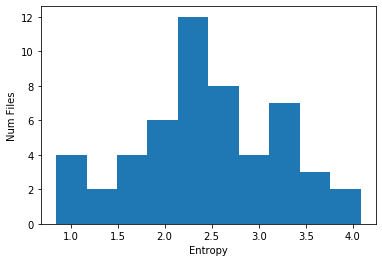

In [21]:
import matplotlib.pyplot as plt
# import seaborn as sns

plt.hist(entropies, bins = 10)
plt.ylabel("Num Files")
plt.xlabel("Entropy")
plt.show()

In [65]:
freq = [.8, .1, .1]
toks = [str(i) for i in range(len(freq))]

d = dit.Distribution(toks, freq)
print(dit.shannon.entropy(d))
print(manual_shannon(freq))

0.9219280948873623
0.9219280948873625


In [0]:
#Rank the system/datasets according to the confidence intervals
#Compute the confidence intervals for all cross-entropy values
#Rank the systems/datasets according to cross-entropy values
#Top 50 most frequent tokens of each system and corpus (one system has generally two corpora)
#Top 50 least frequent tokes of each system and corpus
#What are the tokens that are in the target and not in the source (and the other way around)? Compute the distribution for those tokens
#What are the mutual tokens (source and target)? please compute distribution
#-Compute confidence intervals for the software metrics on source code (e.g., cyclo, loc, lcom5)


In [0]:
Visualize

In [0]:
Push updated fields to Mongo